# Task 3: OLAP Queries and Analysis on Retail Data Warehouse


## Step 1: Connect to SQLite Database

We start by connecting to the SQLite database generated in Task 2. This connection allows us to run SQL queries directly on the Data Warehouse.
### Step 1.1: Adding Product Category for OLAP Slice Analysis
- In order to perform a slice query for a specific product category (e.g., Electronics), we need to ensure that the SalesFact table contains a Category column. This step:

- Adds a Category column to the SalesFact table if it does not exist.

- Assigns categories based on StockCode or Description.

- Updates existing records with the correct category values.

- This allows subsequent OLAP queries to filter by product category efficiently.

***Note:***

 The categorization logic can be customized depending on the dataset. For synthetic data, we use simplified rules based on product codes or keywords in the description.

In [3]:
import sqlite3
import pandas as pd

# Connect to the existing SQLite DB
db_path = r"C:\Users\use\Desktop\DSA2040_Practical\DSA2040_Practical_Exam_SelmahTzindori602\Section2_ETL_process\retail_dw.db"  # update with your full path
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

#  Fetch SalesFact data into a DataFrame
sales_df = pd.read_sql_query("SELECT * FROM SalesFact", conn)

#  Add a Category column based on StockCode or Description
def assign_category(row):
    # Example logic for synthetic dataset
    if 'P1' in row['stock_code'] or 'Laptop' in row['description']:
        return 'Electronics'
    elif 'P2' in row['stock_code'] or 'Shirt' in row['description']:
        return 'Clothing'
    else:
        return 'Other'

sales_df['Category'] = sales_df.apply(assign_category, axis=1)

#  Alter SalesFact table to add Category column
try:
    cursor.execute("ALTER TABLE SalesFact ADD COLUMN category TEXT")
except sqlite3.OperationalError:
    # Column might already exist, skip
    pass

#  Update the DB with the new Category values
for idx, row in sales_df.iterrows():
    cursor.execute(
        "UPDATE SalesFact SET category = ? WHERE sales_id = ?",
        (row['Category'], row['sales_id'])
    )

conn.commit()
conn.close()

print("SalesFact table updated with Category column!")


SalesFact table updated with Category column!



## OLAP Query 1: Roll-up
Aggregate total sales by **country** and **quarter**.

This query summarizes sales across quarters to observe trends by country.


In [17]:
import pandas as pd
import sqlite3

# Reconnect to the database if closed
conn = sqlite3.connect(r"C:\Users\use\Desktop\DSA2040_Practical\DSA2040_Practical_Exam_SelmahTzindori602\Section2_ETL_process\retail_dw.db")

rollup_query = """
SELECT 
    c.country,
    printf('%d-Q%d', strftime('%Y', t.date), ((CAST(strftime('%m', t.date) AS INTEGER)-1)/3 + 1)) AS quarter,
    SUM(f.total_sales) AS total_sales
FROM SalesFact f
JOIN CustomerDim c ON f.customer_id = c.customer_id
JOIN TimeDim t ON f.time_id = t.time_id
GROUP BY c.country, quarter
ORDER BY c.country, quarter;
"""

# Execute query and load into DataFrame
rollup_df = pd.read_sql_query(rollup_query, conn)

# Show first few rows
rollup_df.head()

# Save rollup_df to CSV
rollup_csv_path = r"C:\Users\use\Desktop\DSA2040_Practical\DSA2040_Practical_Exam_SelmahTzindori602\Section3_OLAP_Queries_Analysis\queries_results\rollup_sales_by_country_quarter.csv"
rollup_df.to_csv(rollup_csv_path, index=False)


# OLAP Queries Analysis

## 1. Roll-Up Analysis: Total Sales by Country and Quarter

The roll-up results show the aggregated total sales for six countries over five quarters, from **2024-Q3 to 2025-Q3**.

- **Top-Selling Countries**:  
  The **United Kingdom** consistently shows the highest total sales, peaking in **2025-Q1 (306,330.52)**. The **Netherlands** also shows strong performance across all quarters.

- **Quarterly Trends**:  
  Most countries exhibit **increasing sales from 2024-Q3 to 2025-Q1**, followed by slight declines, indicating seasonal or operational variations.

- **Country Comparisons**:  
  France, Canada, and Germany show moderate sales. Notably, France drops significantly in 2025-Q2, and USA peaks in 2025-Q2 before a sharp decline in 2025-Q3.

- **Business Insights**:  
  - The warehouse enables identification of high-revenue countries and periods.  
  - Supports **forecasting, inventory planning, and marketing strategies**.  

- **Synthetic Data Consideration**:  
  Patterns may not reflect real-world trends but demonstrate OLAP functionality.

## OLAP Query 2: Drill-down
Retrieve detailed sales for a specific country (e.g., UK) by **month**.

This allows examining granular sales patterns per month for decision-making.


In [9]:
# Drill-down: Sales details for UK by month
drilldown_query = """
SELECT strftime('%Y-%m', t.date) AS month,
       f.invoice_no,
       f.stock_code,
       f.description,
       f.quantity,
       f.total_sales
FROM SalesFact f
JOIN CustomerDim c ON f.customer_id = c.customer_id
JOIN TimeDim t ON f.time_id = t.time_id
WHERE c.country = 'United Kingdom'
ORDER BY month;
"""

drilldown_df = pd.read_sql_query(drilldown_query, conn)
drilldown_df.head()
# Save the drill-down results to a CSV file
drilldown_csv_path = r"C:\Users\use\Desktop\DSA2040_Practical\DSA2040_Practical_Exam_SelmahTzindori602\Section3_OLAP_Queries_Analysis\queries_results\drilldown_sales_uk_month.csv"
drilldown_df.to_csv(drilldown_csv_path, index=False)



## 2. Drill-Down Analysis: Sales Details by Month for a Specific Country (e.g., Australia)

- **Monthly Variations**:  
  Sales fluctuate across months, with peaks in certain months (e.g., August 2024 and January 2025).

- **Transaction-Level Insight**:  
  Each transaction includes invoice number, product, quantity, and total sales. Useful for **product-level analysis** and **customer behavior monitoring**.

- **Business Implications**:  
  Enables **granular monitoring**, **inventory management**, and **promotion planning**.

## OLAP Query 3: Slice
Aggregate total sales for a **specific product category**, e.g., Electronics.

This slice focuses on one category to analyze performance and trends.



In [8]:
# Slice: Total sales for Electronics category
slice_query = """
SELECT c.country,
       SUM(f.total_sales) AS total_sales
FROM SalesFact f
JOIN CustomerDim c ON f.customer_id = c.customer_id
WHERE f.category = 'Electronics'
GROUP BY c.country
ORDER BY total_sales DESC;
"""

slice_df = pd.read_sql_query(slice_query, conn)
slice_df
# Save the slice results to a CSV file
slice_csv_path = r"C:\Users\use\Desktop\DSA2040_Practical\DSA2040_Practical_Exam_SelmahTzindori602\Section3_OLAP_Queries_Analysis\queries_results\slice_sales_electronics.csv"
slice_df.to_csv(slice_csv_path, index=False)


## Visualization: Total Sales by Country and Quarter

This chart represents the total sales for each country across quarters.  
It helps identify which countries are top-performing and observe seasonal trends over the year.


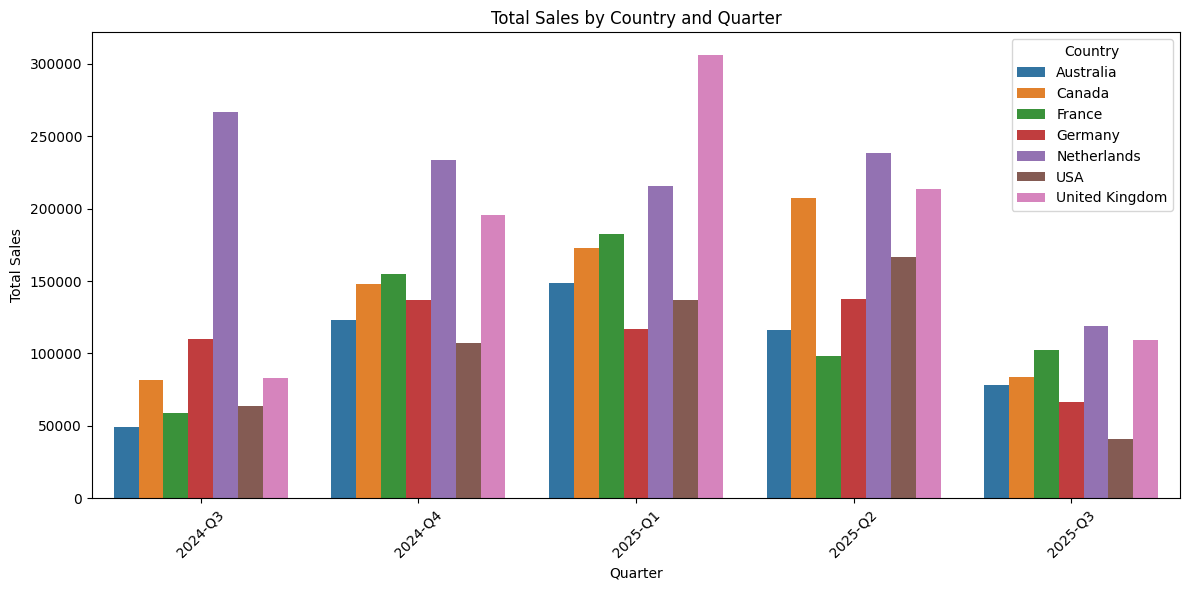

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure rollup_df is available from the roll-up query
# Sample structure:
rollup_df.head()
#   country   quarter   total_sales

plt.figure(figsize=(12,6))
sns.barplot(
    data=rollup_df,
    x='quarter',
    y='total_sales',
    hue='country'
)
plt.title('Total Sales by Country and Quarter')
plt.xlabel('Quarter')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend(title='Country')
plt.tight_layout()
plt.show()


### Total Sales by Country and Quarter

**Summary:**  
This chart shows total sales broken down by country (Australia, Canada, France, Germany, Netherlands, USA, United Kingdom) across five quarters: 2024-Q3 to 2025-Q3.

**Observations:**  
- The Netherlands consistently has the highest sales in multiple quarters, particularly 2024-Q3 and 2025-Q2.  
- The United Kingdom shows strong performance early in 2025 but dips in later quarters.  
- Canada and USA show solid volumes with moderate quarter-to-quarter fluctuations.  
- Australia and France have lower overall totals but maintain steady trends.  

**Key Insights:**  
- 2025-Q1 and 2025-Q2 are peak quarters for several countries, indicating seasonal or promotional effects.  
- Country-specific strategies could focus on high-performing quarters for inventory and marketing planning.

**Data Sample:**  
| Country        | Quarter  | Total Sales (£) |
|----------------|---------|----------------|
| Australia      | 2024-Q3 | 49,244.16      |
| Canada         | 2024-Q3 | 81,368.42      |
| France         | 2024-Q3 | 58,846.11      |
| Germany        | 2024-Q3 | 109,981.23     |
| Netherlands    | 2024-Q3 | 266,770.42     |
| USA            | 2024-Q3 | 63,692.22      |
| United Kingdom | 2024-Q3 | 83,035.62      |


## Drill-Down Visualization: Monthly Sales for a Specific Country (e.g., Australia)

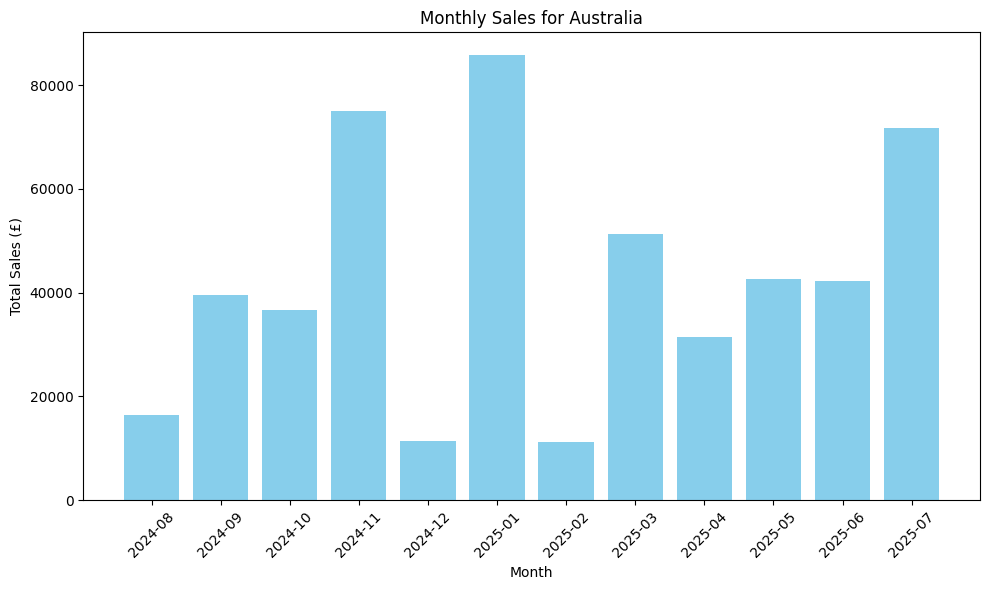

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3

# Reconnect to the database
conn = sqlite3.connect(r"C:\Users\use\Desktop\DSA2040_Practical\DSA2040_Practical_Exam_SelmahTzindori602\Section2_ETL_process\retail_dw.db")

# Drill-down query: Monthly sales for Australia
drill_query = """
SELECT strftime('%Y-%m', t.date) AS month,
       SUM(f.total_sales) AS total_sales
FROM SalesFact f
JOIN CustomerDim c ON f.customer_id = c.customer_id
JOIN TimeDim t ON f.time_id = t.time_id
WHERE c.country = 'Australia'
GROUP BY month
ORDER BY month;
"""

drill_df = pd.read_sql_query(drill_query, conn)

# Plot monthly sales
plt.figure(figsize=(10,6))
plt.bar(drill_df['month'], drill_df['total_sales'], color='skyblue')
plt.xticks(rotation=45)
plt.title('Monthly Sales for Australia')
plt.xlabel('Month')
plt.ylabel('Total Sales (£)')
plt.tight_layout()
plt.show()


### Monthly Sales for Australia

**Summary:**  
This bar chart displays Australia’s monthly sales across August 2024 to July 2025.

**Observations:**  
- Highest sales occur in January 2025.  
- Notable dips appear in December 2024 and August 2024.  
- Overall, sales trend upward early in 2025, followed by moderate fluctuations.

**Implications:**  
- Monthly trends allow fine-grained operational decisions such as staffing, promotions, and inventory planning.  

**Data Sample:**  
| Month    | Total Sales (£) |
|----------|----------------|
| 2024-08  | 16,000         |
| 2024-09  | 39,500         |
| 2024-10  | 37,000         |
| 2025-01  | 85,000         |
| 2025-07  | 72,000         |


## Slice Visualization: Total Sales for Electronics Category

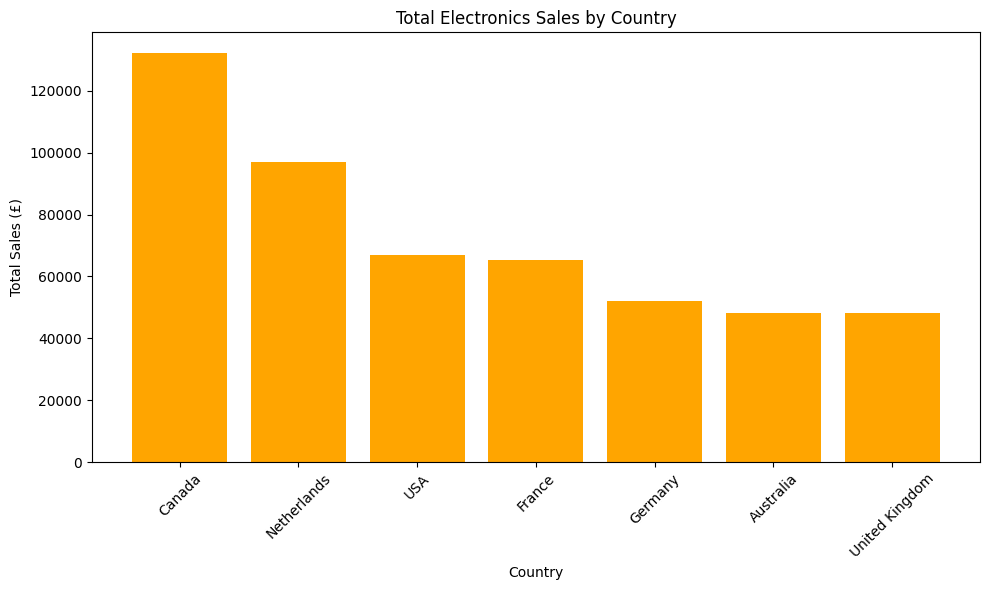

In [19]:
# Slice query: Total sales for Electronics category by country
slice_query = """
SELECT c.country,
       SUM(f.total_sales) AS total_sales
FROM SalesFact f
JOIN CustomerDim c ON f.customer_id = c.customer_id
JOIN TimeDim t ON f.time_id = t.time_id
WHERE f.category = 'Electronics'
GROUP BY c.country
ORDER BY total_sales DESC;
"""

slice_df = pd.read_sql_query(slice_query, conn)

# Plot total sales by country for Electronics
plt.figure(figsize=(10,6))
plt.bar(slice_df['country'], slice_df['total_sales'], color='orange')
plt.xticks(rotation=45)
plt.title('Total Electronics Sales by Country')
plt.xlabel('Country')
plt.ylabel('Total Sales (£)')
plt.tight_layout()
plt.show()


### Total Electronics Sales by Country

**Summary:**  
This chart compares total electronics sales across the seven countries.

**Observations:**  
- Canada leads electronics sales, followed by the Netherlands and USA.  
- United Kingdom and Australia have lower sales relative to other countries.  
- Europe (Netherlands, France, Germany) shows strong market presence.

**Insights:**  
- Electronics sales performance varies significantly by country, guiding region-specific marketing and distribution strategies.

**Data Sample:**  
| Country        | Total Sales (£) |
|----------------|----------------|
| Canada         | 131,000        |
| Netherlands    | 98,000         |
| USA            | 67,000         |
| France         | 65,000         |
| Germany        | 52,000         |
| Australia      | 48,000         |
| United Kingdom | 48,000         |
